In [8]:
import astropy
import numpy as np
import pandas as pd
from astropy.table import Table
import speclite
import speclite.filters
import dynesty
import numba
import astropy.units as units
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import dynesty.plotting as dyplot
import glob
from astropy.time import Time
from datetime import datetime
import speclite
import scipy.signal as signal

In [2]:
# load grond filter curves
grond_flt = Table.read('GROND_filtercurves.txt', format='ascii')
for band in 'grizJHK':
    grond_flt['%sBand' % band][grond_flt['%sBand' % band] < 0] = 0.0
    grond_flt['%sBand' % band][0] = 0.0
    grond_flt['%sBand' % band][-1] = 0.0
grond_flt

<Table length=2151>
  A    gBand   rBand   iBand   zBand   JBand   HBand   KBand 
int64 float64 float64 float64 float64 float64 float64 float64
----- ------- ------- ------- ------- ------- ------- -------
  350     0.0     0.0     0.0     0.0     0.0     0.0     0.0
  351   5e-05   1e-05     0.0     0.0     0.0     0.0     0.0
  352   7e-05   1e-05     0.0     0.0     0.0     0.0     0.0
  353 0.00011   2e-05     0.0     0.0     0.0     0.0     0.0
  354 0.00012   3e-05     0.0     0.0     0.0     0.0     0.0
  355 0.00012   5e-05     0.0     0.0     0.0     0.0     0.0
  356 0.00014   7e-05     0.0     0.0     0.0     0.0     0.0
  357 0.00016   9e-05     0.0     0.0     0.0     0.0     0.0
  358 0.00018 0.00011     0.0     0.0     0.0     0.0     0.0
  359 0.00021 0.00016     0.0     0.0     0.0     0.0     0.0
  ...     ...     ...     ...     ...     ...     ...     ...
 2491     0.0     0.0     0.0     0.0  0.0025  0.0021  0.0028
 2492     0.0     0.0     0.0     0.0  0.0026  0.0021  0.0027
 2493     0.0     0.0     0.0     0.0  0.0026  0.0021  0.0027
 2494     0.0     0.0     0.0     0.0  0.0025  0.0021  0.0026
 2495     0.0     0.0     0.0     0.0  0.0026  0.0021  0.0026
 2496     0.0     0.0     0.0     0.0  0.0025  0.0021  0.0025
 2497     0.0     0.0     0.0     0.0  0.0025  0.0022  0.0025
 2498     0.0     0.0     0.0     0.0  0.0025  0.0022  0.0025
 2499     0.0     0.0     0.0     0.0  0.0025  0.0022  0.0024
 2500     0.0     0.0     0.0     0.0     0.0     0.0     0.0

In [3]:
# setup the grond filter curves
grond_filters = {}
for band in 'grizJHK':
    flt = speclite.filters.FilterResponse(wavelength=grond_flt['A']*units.nm, response=grond_flt['%sBand' % band], meta=dict(group_name='grond', band_name=band))
    grond_filters[band] = flt

In [4]:
df = pd.read_hdf('2020-04-20-grond-lc-v1.h5', key='/lc')
df.set_index('mjd', inplace=True)
df

band    mag_psf  magerr_psf   mag_aper  magerr_aper
mjd                                                      
58764    J  17.415586    0.487994  17.940586     0.111468
58764    K  17.479917    0.189831  18.667917     0.189831
58764    r  17.288038    0.103450  18.451038     0.104600
58764    g  18.921990    0.255250  19.426990     0.109200
58764    H  17.198348    0.176452  18.124348     0.121024
58764    z  16.776398    0.109200  17.968398     0.106900
58764    i  17.026589    0.106900  18.203589     0.105750
58772    K        NaN         NaN  19.310337     0.348469
58772    i  19.150641    0.577250  18.281641     0.116100
58772    r  18.132621    0.240300  18.612621     0.113800
58772    g  18.921460    0.353714  19.711460     0.153614
58772    H  16.244993    0.491816  18.755993     0.184097
58772    z  16.929763    0.148300  18.087763     0.117250
58772    J  17.308753    0.163073  18.369753     0.140137
58774    z  18.085149    0.189700  18.221149     0.109200
58774    K  17.646184    0.195565  18.806184     0.195565
58774    i  17.249597    0.105750  18.328597     0.106900
58774    J  18.473258    0.759398  18.227258     0.117202
58774    H  16.540829    0.556801  18.547829     0.143960
58774    r  18.255861    0.175900  18.906861     0.105750
58774    g  18.540936    0.106900  19.630936     0.108050
58778    J  17.346154    0.170718  18.394154     0.119113
58778    i  17.331735    0.106900  18.390735     0.106900
58778    K  17.865141    0.231880  19.111141     0.226146
58778    H  17.329571    0.191742  18.433571     0.134403
58778    z  16.993435    0.108050  18.058435     0.108050
58778    r  17.635167    0.106900  18.773167     0.105750
58778    g  18.623460    0.109200  19.689460     0.108050
58783    K  17.903996    0.228057  18.973996     0.212767
58783    H  17.448322    0.256727  18.576322     0.128669
58783    r  17.749460    0.105750  19.039460     0.104600
58783    z  17.072423    0.112650  18.098423     0.105750
58783    J  17.473311    0.157339  18.500311     0.115290
58783    i  17.868000    0.162100  18.842000     0.106900
58783    g  18.698648    0.106900  20.608648     0.112650
58789    r  17.839369    0.104600  19.176369     0.103450
58789    g  20.078053    0.194300  19.877053     0.104600
58789    H  17.532856    0.164984  18.596856     0.124847
58789    K  17.935003    0.325533  18.940003     0.323622
58789    J  17.610303    0.178363  18.727303     0.115290
58789    i  17.524556    0.106900  18.691556     0.103450
58789    z  17.130278    0.105750  18.212278     0.103450
58794    r  17.963307    0.103450  19.108307     0.104600
58794    i  17.603845    0.105750  18.653845     0.104600
58794    K  17.970819    0.293041  19.203819     0.340824
58794    g  18.825910    0.106900  20.183910     0.109200
58794    J  17.792990    0.151605  18.706990     0.111468
58794    z  17.200434    0.103450  18.337434     0.104600
58794    H  17.800779    0.216589  18.763779     0.126758
58814    J  18.261869    0.201299  19.214869     0.124847
58814    g  19.593358    0.167850  20.173358     0.106900
58814    K  18.672531    0.256727  19.887531     0.287307
58814    i  17.904210    0.106900  19.078210     0.105750
58814    H  19.753650    0.877899  19.358650     0.147783
58814    r  18.256006    0.104600  19.380006     0.104600
58814    z  17.484213    0.105750  18.751213     0.105750

12.3 µs ± 5.68 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


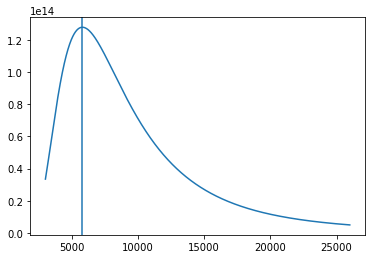

In [2]:
@numba.njit
def prior_transform(u):
    x = np.empty(2)
    # radius [cm]
    #x[0] = 1e10*u[0] + 700e8
    # log prefactor
    x[0] = 120*u[0]
    # temp [K]
    x[1] = 100e3*u[1] + 2000
    return x

wavelength_start = 3000*(units.Angstrom.to(units.cm))
wavelength_end = 26000*(units.Angstrom.to(units.cm))
wavelength_grid = np.linspace(wavelength_start, wavelength_end, 2300)

@numba.njit
#def bbfun(radius, temp):
def bbfun(temp, wave_grid=wavelength_grid):
    flux_factor = 1.1910429526245744e-05
    x_const = 1.4387773538277204
    #pre_factor = flux_factor * (radius ** 2)
    pre_factor = flux_factor
    # (\x -> 1.0 / x**5 / (exp (x_const / x / temp) - 1))
    sed = pre_factor / wave_grid ** 5 / (np.exp(x_const / wave_grid / temp) - 1.0)
    return sed

plt.plot(wavelength_grid*units.cm.to(units.Angstrom), bbfun(5000))
plt.axvline(2897/5000*10e3)
%timeit bbfun(5000)

In [6]:
synphot_convs = []
for band in 'grizJHK':
    conv = speclite.filters.FilterConvolution(response=grond_filters[band], wavelength=wavelength_grid*units.cm)
    print(repr(conv.output_units))
    synphot_convs.append(conv)
    print(repr(conv(bbfun(5000))))

#def synphot(sed):
    

None
2.450197044131914e+28
None
4.416518591478906e+28
None
2.6933503912401045e+28
None
2.8367715640160243e+28
None
3.433192789647347e+28
None
2.6118912143692636e+28
None
1.9332076735633773e+28


/home/welterde/.local/lib/python3.8/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [7]:
def fitsim(df, mjd):
    # select by MJD
    df_sel = df.loc[mjd]
    #rint(df_sel)
    mags = np.empty(7)
    mags_err = np.empty(7)
    for i,band in enumerate('grizJHK'):
        mags[i] = df_sel.query('band == "%s"' % band)['mag_aper']
        mags_err[i] = df_sel.query('band == "%s"' % band)['magerr_aper']
    #mags = np.array([df_sel.query('band == "%s"' % band)['mag_aper'] for band in 'grizJHK'])
    
    flt_seq = speclite.filters.FilterSequence([grond_filters[band] for band in 'grizJHK'])
    
    def loglike(x):
        pre_factor = x[0] #10**x[0]
        temp = x[1]
        
        # calculate SED
        sed = bbfun(temp)
        
        synphot = flt_seq.get_ab_magnitudes(sed, wavelength_grid*units.cm)
        mags_syn = np.array([synphot['grond-%s' % band][0] for band in 'grizJHK'])
        mags_syn += pre_factor
        
        sigma2 = mags_err**2
        #return -0.5 * np.sum((mags - mags_syn)**2)
        return np.sum((mags - mags_syn)**2 / sigma2)
    
    #sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=2)
    #sampler.run_nested()
    #return sampler.results
    res = differential_evolution(loglike, [(1, 120), (3000, 300e3)])
    return res

In [8]:
num_epochs = len(np.unique(df.index.get_level_values('mjd')))
mjds = np.empty(num_epochs)
temp = np.empty(num_epochs)
offset = np.empty(num_epochs)
i = 0

for mjd in np.unique(df.index.get_level_values('mjd')):
    results = fitsim(df, mjd)
    mjds[i] = mjd
    offset[i] = results.x[0]
    temp[i] = results.x[1]
    i += 1
    #dyplot.runplot(results)
    #print(results)
    #break

/home/welterde/.local/lib/python3.8/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


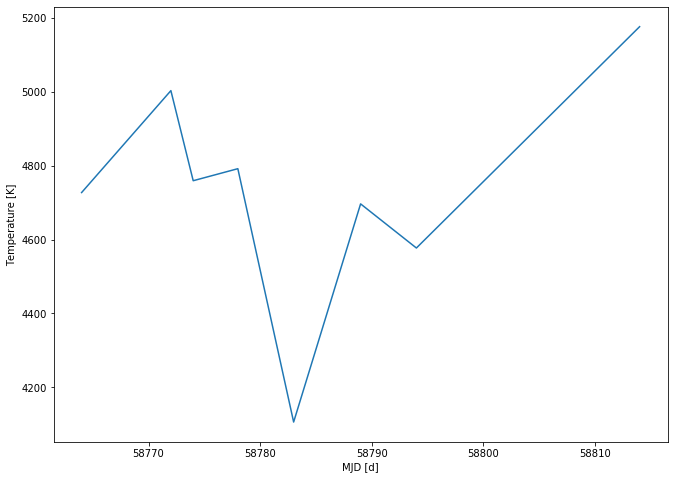

In [10]:
plt.figure(figsize=(11,8))
plt.plot(mjds, temp)
plt.xlabel('MJD [d]')
plt.ylabel('Temperature [K]')
plt.savefig('2020-04-20-phot-temp-evolution.png')

In [14]:
df.loc[58814]

band    mag_psf  magerr_psf   mag_aper  magerr_aper
mjd                                                      
58814    J  18.261869    0.201299  19.214869     0.124847
58814    g  19.593358    0.167850  20.173358     0.106900
58814    K  18.672531    0.256727  19.887531     0.287307
58814    i  17.904210    0.106900  19.078210     0.105750
58814    H  19.753650    0.877899  19.358650     0.147783
58814    r  18.256006    0.104600  19.380006     0.104600
58814    z  17.484213    0.105750  18.751213     0.105750

In [64]:
speclite.filters.load_filters('sdss2010-g', 'sdss2010-r').get_ab_magnitudes(bbfun(5000), wavelength_grid*units.cm)

/home/welterde/.local/lib/python3.8/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


<Table length=1>
     sdss2010-g         sdss2010-r    
      float64            float64      
------------------- ------------------
-55.886392613169996 -56.60845598446955

In [75]:
speclite.filters.FilterSequence(grond_filters.values()).get_ab_magnitudes(bbfun(5000), wavelength_grid*units.cm)['grond-g'][0]

-55.80333579402207

In [114]:
flt_seq = speclite.filters.FilterSequence([grond_filters[band] for band in 'grizJHK'])
for temp in [5000, 10e3, 30e3]:
    # calculate SED
    sed = bbfun(temp)
        
    synphot = flt_seq.get_ab_magnitudes(sed, wavelength_grid*units.cm)
    gr = synphot['grond-g'][0] - synphot['grond-i'][0]
    JK = synphot['grond-J'][0] - synphot['grond-K'][0]
    print(temp, gr, JK)
    #print(synphot)

5000 1.102662141680419 -0.4868679801455045
10000.0 -0.15145026995725175 -0.8429734495847754
30000.0 -0.8684320516869946 -1.036984108514595


/home/welterde/.local/lib/python3.8/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


In [117]:
def blah(df, mjd):
    # select by MJD
    df_sel = df.loc[mjd]
    #rint(df_sel)
    mags = np.empty(7)
    mags_err = np.empty(7)
    for i,band in enumerate('grizJHK'):
        mags[i] = df_sel.query('band == "%s"' % band)['mag_aper']
        mags_err[i] = df_sel.query('band == "%s"' % band)['magerr_aper']
    return mags[1] - mags[5]

for mjd in np.unique(df.index.get_level_values('mjd')):
    print(mjd, blah(df, mjd))

58764 0.32669012696057464
58772 -0.143372256256022
58774 0.35903214436573094
58778 0.33959535292037657
58783 0.46313792832485134
58789 0.5795126997642903
58794 0.3445275231280114
58814 0.021355982740040247


In [36]:
def fitspec(spec):
    wave = spec['col1']
    flux = signal.medfilt(spec['col2']/np.nanmean(spec['col2']), 11)
    flux_err = spec['col3']/np.nanmean(spec['col2'])
    
    
    
    def loglike(x):
        #pre_factor = x[0] #10**x[0]
        pre_factor = 10**x[0]
        temp = x[1]
        
        # calculate SED
        sed = pre_factor*1e14*bbfun(temp, wave)
        
        #synphot = flt_seq.get_ab_magnitudes(sed, wavelength_grid*units.cm)
        #mags_syn = np.array([synphot['grond-%s' % band][0] for band in 'grizJHK'])
        #mags_syn += pre_factor
        
        sigma2 = flux_err**2
        
        #return 0.5 * np.sum(((flux-sed)/flux)**2 / sigma2)
        return np.sum(np.abs(flux-sed))
        #sigma2 = mags_err**2
        #return -0.5 * np.sum((mags - mags_syn)**2)
        #return np.sum((mags - mags_syn)**2 / sigma2)
    
    #sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=2)
    #sampler.run_nested()
    #return sampler.results
    res = differential_evolution(loglike, [(-40, 40), (3000, 120e3)])
    return res, bbfun(res.x[1], wave), flux

def fitspec2(spec):
    wave = spec['col1']
    flux = signal.medfilt(spec['col2']/np.nanmean(spec['col2']), 21)
    flux_err = spec['col3']/np.nanmean(spec['col2'])
    
    
    
    def loglike(x):
        temp = x[0]
        
        # calculate SED
        #sed = pre_factor*1e14*bbfun(temp, wave)
        sed = bbfun(temp, wave)
        
        #synphot = flt_seq.get_ab_magnitudes(sed, wavelength_grid*units.cm)
        #mags_syn = np.array([synphot['grond-%s' % band][0] for band in 'grizJHK'])
        #mags_syn += pre_factor
        
        sigma2 = flux_err**2
        
        return 0.5 * np.sum(((flux-sed/np.nanmean(sed))/flux)**2 / sigma2)
        #return np.sum(np.abs(flux-sed/np.nanmean(sed)))
        #sigma2 = mags_err**2
        #return -0.5 * np.sum((mags - mags_syn)**2)
        #return np.sum((mags - mags_syn)**2 / sigma2)
    
    #sampler = dynesty.DynamicNestedSampler(loglike, prior_transform, ndim=2)
    #sampler.run_nested()
    #return sampler.results
    res = differential_evolution(loglike, [(3000, 120e3)])
    sed = bbfun(res.x[0], wave)
    return res, sed/np.nanmean(sed), flux

In [37]:
# load specs
#specs = []
mjds = []
temps = []
for fname in glob.glob('*P60*.ascii'):
    spec = Table.read(fname, format='ascii')
    t = fname.split('_')[1]
    ts = Time(datetime.strptime(t, '%Y%m%d'))
    mjds.append(ts.mjd)
    print(fname, t)
    x, sed, smoothed = fitspec2(spec)
    #plt.plot(spec['col1'], spec['col2']/np.nanmean(spec['col2']))
    #plt.plot(spec['col1'], sed)
    #plt.plot(spec['col1'], smoothed)
    #break
    #print(x)
    temps.append(x.x[0])
    #print(spec)

ZTF19abqwtfu_20190821_P60_v1.ascii 20190821


<ipython-input-36-bfc4ab9142e6>:54: RuntimeWarning: divide by zero encountered in true_divide
  return 0.5 * np.sum(((flux-sed/np.nanmean(sed))/flux)**2 / sigma2)
<ipython-input-36-bfc4ab9142e6>:54: RuntimeWarning: Mean of empty slice
  return 0.5 * np.sum(((flux-sed/np.nanmean(sed))/flux)**2 / sigma2)


ZTF19abqwtfu_20190823_P60_v1.ascii 20190823
ZTF19abqwtfu_20190824_P60_v1.ascii 20190824
ZTF19abqwtfu_20190827_P60_v1.ascii 20190827
ZTF19abqwtfu_20190831_P60_v1.ascii 20190831
ZTF19abqwtfu_20190910_P60_v1.ascii 20190910
ZTF19abqwtfu_20190917_P60_v1.ascii 20190917
ZTF19abqwtfu_20190922_P60_v1.ascii 20190922
ZTF19abqwtfu_20190927_P60_v1.ascii 20190927
ZTF19abqwtfu_20191006_P60_v1.ascii 20191006
ZTF19abqwtfu_20191013_P60_v2.ascii 20191013
ZTF19abqwtfu_20191019_P60_v1.ascii 20191019
ZTF19abqwtfu_20191026_P60_v1.ascii 20191026
ZTF19abqwtfu_20191103_P60_v1.ascii 20191103
ZTF19abqwtfu_20191110_P60_v1.ascii 20191110
ZTF19abqwtfu_20191123_P60_v1.ascii 20191123
ZTF19abqwtfu_20191218_P60_v1.ascii 20191218
ZTF19abqwtfu_20191221_P60_v1.ascii 20191221
ZTF19abqwtfu_20200103_P60_v1.ascii 20200103


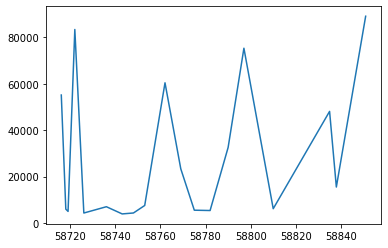

In [38]:
plt.plot(mjds, temps)